# **AP157 Machine Learning Lab Assignment**
## Module A.3: Dimensionality Reduction -- Principal Component Analysis of SDSS Galaxy Spectra

_Instructions_: Answer each part of the assignment as completely as you can. Discuss **all** your code and results as clearly and concisely as possible.

_Scoring Criteria_: 50% - *correctness of code*; 50% - *discussion of the code and results*. Maximum score is **100 points** (Parts 1 and 2 are worth 25 and 75 points, respectively).

_Credits_: This assignment is based on the scikit-learn tutorial "Dimensionality Reduction of Astronomical Spectra" ([link](https://ogrisel.github.io/scikit-learn.org/sklearn-tutorial/tutorial/astronomy/dimensionality_reduction.html))

### Student Information

_Full Name (Last Name, First Name)_: Mendoza, Genesis Adam \
_Student No._: 2019-05415 \
_Section_: THY-TX-2

### Submission Information

_Date and Time Submitted (most recent upload)_: 05/03/2024 - 8:30 PM

**HONOR PLEDGE** I affirm that I have upheld the highest principles of honesty and integrity in my academic work and that this lab assignment is my own work.

**Sign here with your full name:** GENESIS ADAM D. MENDOZA

### Grading Information (c/o Instructor)

TOTAL SCORE: **[]**/100

Score breakdown:
* Part 1 - []/25
* Part 2 - []/75

_Date and Time Scored (MM/DD/YYYY HH:MM AM/PM):_

Define the directory path to the location of the file, i.e. if it is in a
folder named "AP157" under My Drive, then the file path will be "/content/drive/My Drive/AP157". Change the string variable in the code cell below, as needed:

In [1]:
file_path = "..//datasets//"

Now, we can load the file using $\tt numpy$'s $\tt load$ function below.


In [2]:
import numpy as np
import pandas as pd

data = np.load(file_path + 'spec4000_corrected.npz')
data_pd = pd.DataFrame(data)
data_pd.head()

,0
0,spec_recons
1,wavelength


The NpzFile object is a dictionary-like object which can be queried for its list of arrays and the arrays themselves ([reference](https://numpy.org/doc/stable/reference/generated/numpy.savez.html)). Our object contains two arrays: ``spec_recons`` - 4000 reconstructed SDSS spectra each with 1000 attributes (flux in units of $10^{-17}$ erg cm$^{-2}$ s$^{-1}$ Å$^{-1}$) and ``wavelength`` - array of wavelengths (in units of Angstroms) corresponding to these attributes.

In [3]:
data.files

['spec_recons', 'wavelength']

In [4]:
np.shape(data['spec_recons']), np.shape(data['wavelength'])

((4000, 1000), (1000,))

Let's plot the first few spectra to visualize our data

In [5]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 100
plt.rcParams['lines.linewidth'] = 0.75

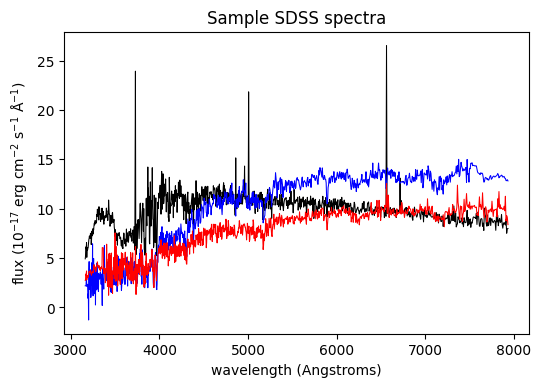

In [6]:
wavelength = data['wavelength']
flux0 = data['spec_recons'][0,:]
flux1 = data['spec_recons'][1,:]
flux2 = data['spec_recons'][2,:]

plt.plot(wavelength, flux0, 'k-')
plt.plot(wavelength, flux1, 'b-')
plt.plot(wavelength, flux2, 'r-')
plt.ylabel("flux ($10^{-17}$ erg cm$^{-2}$ s$^{-1}$ Å$^{-1}$)")
plt.xlabel("wavelength (Angstroms)")
plt.title("Sample SDSS spectra")
plt.show()

#### PART 1 - Get mean normalized spectrum *(25 pts.)*

Plot the mean spectrum by first normalizing the spectra and plot the mean and standard deviation. For this, you may use the ``normalize`` function in scikit-learn's preprocessing module [(documentation)](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html). Describe the mean spectrum and note wavelengths with the highest variation across the sample. What is the reason for this variation?


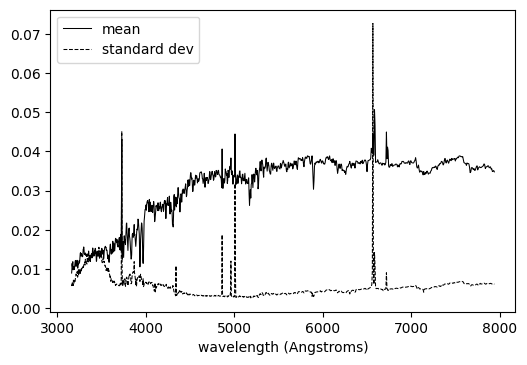

In [7]:
from sklearn.preprocessing import normalize

spectra = data['spec_recons']
norm_spectra = normalize(spectra, axis = 1)

mean = np.mean(norm_spectra, axis = 0) 
st_dev = np.std(norm_spectra, axis = 0)

plt.plot(wavelength, mean, 'k-', label = 'mean')
plt.plot(wavelength, st_dev, 'k--', label = 'standard dev')
plt.xlabel("wavelength (Angstroms)")
plt.legend()
plt.show()

Alternative visualization:

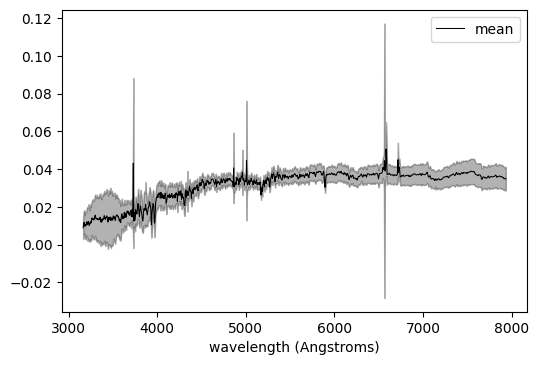

In [8]:
plt.plot(wavelength, mean, 'k-', label = 'mean')
plt.fill_between(wavelength, mean - st_dev, mean + st_dev, where=(mean + st_dev) > 0, interpolate=True, color='k', alpha=0.3)
plt.xlabel("wavelength (Angstroms)")
plt.legend()
plt.show()

The mean spectrum has a general increasing trend but it seems to plateau eventually. There are discernible sharp peaks and dips. The peaks represent emission and the dips represent absorption. We can identify the wavelengths with sharp peaks using the standard deviation array. A pretty crude way to do this is to take all the standard deviation point and evaluate its forward slope and backward slope. If it is steep enough, say, the magnitude of both slopes around a point is greater than $\epsilon$, then it is a peak.

In [9]:
eps = 0.0008

peak_wavelength = [wavelength[i] for i in range(wavelength.size - 1) if ((st_dev[wavelength == wavelength[i]] - st_dev[wavelength == wavelength[i-1]]))/(wavelength[i]-wavelength[i-1]) > eps and ((st_dev[wavelength == wavelength[i+1]] - st_dev[wavelength == wavelength[i]]))/(wavelength[i+1]-wavelength[i]) < -eps]
print('The peaks are at: {}'.format(peak_wavelength))

The peaks are at: [3729.065399621527, 4341.1020970734535, 4861.832584649837, 4961.351535855692, 5007.258356403348, 6564.47501951699]


According to the table of spectral lines from the [SDSS website](https://classic.sdss.org/dr6/algorithms/linestable.php), the prominent peaks we have found corresponds to $\text{O II}$, $\text{H}\, \gamma$, $\text{H}\, \beta$, $\text{O III}$, and $\text{H}\, \alpha$ emission lines. We can digress a little bit and talk about Fourier transform. We can create a high-pass and a low-pass filter for our data. Low frequencies capture the important features of the plot, while the high frequencies are just noises.

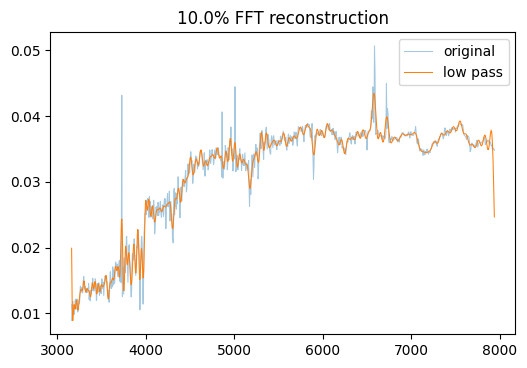

In [10]:
def data_filters(array, percent):
    array_fft = np.fft.rfft(array) #assuming that array contains real entries
    bounds = int(percent*len(mean)) 
    mean_low_pass = np.copy(array_fft)
    mean_low_pass[bounds:] = 0  #suppress high freq entries
    mean_high_pass = np.copy(array_fft)
    mean_high_pass[:-bounds] = 0 #suppress low freq entries

    low_pass = np.fft.irfft(mean_low_pass) #reverse the fft
    high_pass = np.fft.irfft(mean_high_pass)

    return low_pass, high_pass

reconst = 0.1
lp, hp = data_filters(mean, reconst)
plt.plot(wavelength, mean, label = 'original', alpha = 0.4)
plt.plot(wavelength, lp, label = 'low pass')
plt.title(str(reconst*100)+'% FFT reconstruction')
plt.legend()
plt.show()

As we can see, we have captured the striking trends from our data with just the first $10\%$ of the frequencies. Furthermore, we can faithfully reconstruct the data as we increase the considered frequencies.

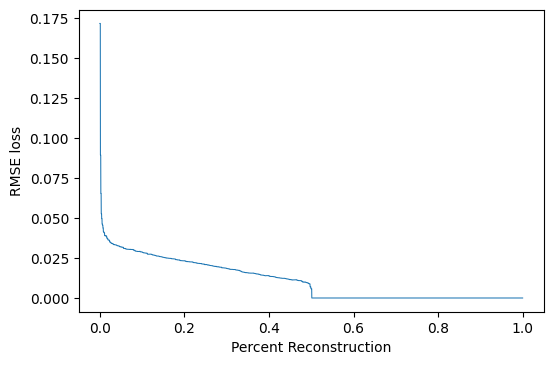

In [11]:
from sklearn.metrics import mean_absolute_error

def fourier_loss_plot(array):
    error_vals = []
    percent_space = np.linspace(0,1,10000)
    for val in percent_space:
        lp, hp = data_filters(mean, val)
        error_vals.append(np.sqrt(mean_absolute_error(array, lp))) #take the mean absolute error between the orig data and reconstruction
    plt.plot(percent_space, error_vals)
    plt.xlabel('Percent Reconstruction')
    plt.ylabel('RMSE loss')
    plt.show()

fourier_loss_plot(mean)

High accuracy came a little bit early, with an almost $0$ loss at around $50\%$ of the frequencies. Now, we can extract the peaks of our data by subtracting the low-frequency reconstruction to the original data.

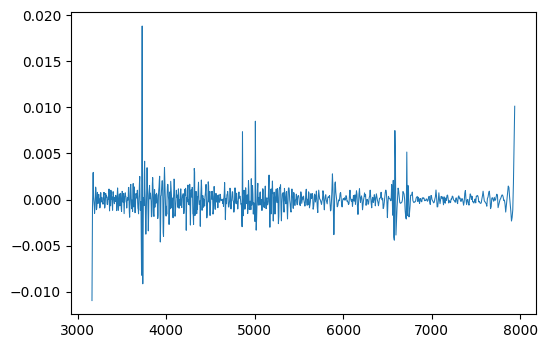

In [12]:
peaks = mean-lp
plt.plot(wavelength, peaks, label = 'low pass')
plt.show()

In [13]:
eps = 0.00055

peak_wave = [wavelength[i] for i in range(wavelength.size-1) if ((peaks[i] - peaks[i-1]))/(wavelength[i]-wavelength[i-1]) > eps and ((peaks[i+1]-peaks[i]))/(wavelength[i+1]-wavelength[i]) < -eps]
print('The peaks are at: {}'.format(peak_wave))

The peaks are at: [3729.065399621527, 4861.832584649837, 4961.351535855692, 5007.258356403348, 6564.47501951699, 6717.381285473806]


Some points here are similar to what we found earlier.

#### PART 2 - Get principal components *(75 pts.)*

Perform Principal Component Analysis (PCA) and visualize the top principal components:
1. Get the first 4 principal components using the ``PCA`` function in scikit-learn's decomposition module [(documentation)](https://scikit-learn.org/0.15/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA). Make sure to use the normalized spectra as input. *(25 pts.)*


In [14]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4) #specify the number of components
pca_spec = pca.fit_transform(norm_spectra) #find the PCA parameters and transform the data accordingly.
print(pca_spec)

[[ 0.22971489  0.01853734  0.07516665 -0.01701655]
 [-0.11125729 -0.0416789  -0.02533317  0.00998591]
 [-0.02065166 -0.06298815  0.00405862  0.0073455 ]
 ...
 [ 0.13285351  0.06791995  0.10341355 -0.05075213]
 [-0.0477309  -0.03604383 -0.01644559 -0.01015834]
 [-0.02538428 -0.0439059   0.02283272 -0.00113296]]


2. Plot the first two principal components (coefficient 1 in the x axis and coefficient 2 in the y axis). Make sure to label the axes and good to set x and y axis limits to be equal. *(25 pts.)*

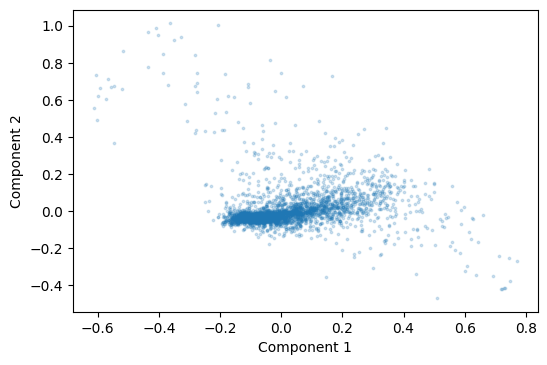

In [15]:
plt.scatter(pca_spec[:,0],pca_spec[:,1], s = 3, alpha = 0.2) #take the first entries to be x and the second entries to be y
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

It can be seen that there is a heavy streak of points horizontally from -0.2 to 0.2. This suggests that there is a dominant trend in the data that is captured by these two principal components. In addition, there are sparse points that looks like it is distributed diagonally. This may represent a minor trend that possibly contributes to the variability of the data.

3. Plot the first 4 eigenvectors together with the mean spectrum. Add an arbitrary y-offset between the spectra for clarity. *(25 pts.)*

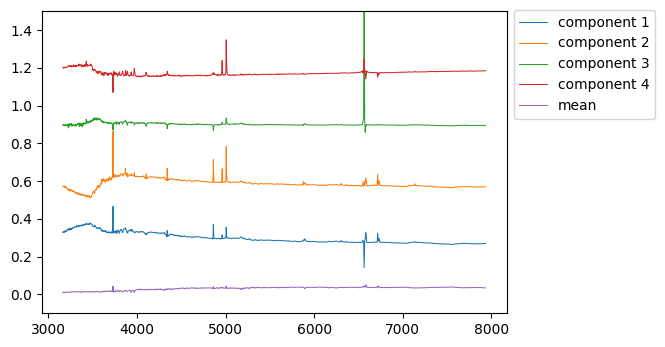

In [16]:
eigenvec = pca.components_ #pca components correspond to the eigenvectors of the covariance matrix
eigenval = pca.explained_variance_ #pca explained variance correspond to the eigenvalues of the covariance matrix

for i in range(4):
    plt.plot(wavelength, 0.3+eigenvec[i]+0.3*i, label = 'component '+str(i+1))

plt.plot(wavelength, mean, label = 'mean')
plt.legend(bbox_to_anchor = (1, 1.0275))
plt.ylim(-0.1, 1.5)
plt.show()

Each component here represents a specific detail about the spectra. The first component was expected to contain more information compared to the next one. It can be seen that each of them highlights different aspects of the data. 